In [19]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt

# utility function
# @tf.function


def u(c):
    return c**(1/2)


def u_deriv(c):
    return c**(-1/2)/2


# @tf.function
def u_deriv_inv(c):
    return c**(-2)/4


def F0_deriv(w):
    return -2*w


def F0(w):
    return -w**2


def h(a):
    return 1/2*a**2 + 0.4 *a

def gamma(a):
    return a+0.4
# Define initial condition
# def fun_u_0(x):
#     return -tf.sin(pi * x)

# Define boundary condition
def fun_lb(w):
    n = w.shape[0]
    return tf.zeros((n, 1), dtype=DTYPE)


# def fun_ub(w):
#     return F0(w)


def fun_ub(w):
    return F0_deriv(w)

# Set data type
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

# Parameter
r = 0.1
sigma = 1

# Set constants
# gamma = tf.constant(gamma, dtype=DTYPE)
# r = tf.constant(r, dtype=DTYPE)
# rho = tf.constant(rho, dtype=DTYPE)
# # zmean = tf.constant(zmean, dtype=DTYPE)
# the = tf.constant(the, dtype=DTYPE)
# sig2 = tf.constant(sig2, dtype=DTYPE)

# cap_u = tf.Variable(cap_u, dtype=DTYPE)
# cap_c = tf.Variable(cap_c, dtype=DTYPE)



# Set number of data points
N_b = 2
N_r = 10000

# Set boundary
# zmean = np.exp(Var/2)

wmin = 0
wmax = 1
# zmin = zmean*0.8
# zmax = zmean*1.2




In [20]:

# Lower bounds
lb = tf.constant([wmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([wmax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)


w_lb = lb[0] * tf.ones((N_b, 1), dtype=DTYPE)
X_lb = tf.concat([w_lb], axis=1)

# # Evaluate boundary condition at (t_b,x_b)
V_lb = fun_lb(X_lb)


w_ub = ub[0] * tf.ones((N_b, 1), dtype=DTYPE)
X_ub = tf.concat([w_ub], axis=1)

# # # Evaluate boundary condition at (t_b,x_b)
V_ub = fun_ub(X_ub)
# X_lb, V_lb,X_ub, V_ub

X_eq = X_lb
V_eq = V_lb

X_NBC = w_ub
V_NBC = V_ub

w_r = tf.random.uniform((N_r, 1), lb[0], ub[0], dtype=DTYPE)

X_r = tf.concat([w_r], axis=1)
# X_r[:,0:1].shape


In [21]:
# Define model architecture
class PINN_NeuralNet(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
                 output_dim=1,
                 num_hidden_layers=8,
                 num_neurons_per_layer=20,
                 activation='tanh',
                 kernel_initializer='glorot_normal',
                 **kwargs):
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        self.lb = lb
        self.ub = ub

        # Define NN architecture
        self.scale = tf.keras.layers.Lambda(
            lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                                             activation=tf.keras.activations.get(
                                                 activation),
                                             kernel_initializer=kernel_initializer)
                       for _ in range(self.num_hidden_layers)]
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, X):
        """Forward-pass through neural network."""
        Z = self.scale(X)
        for i in range(self.num_hidden_layers):
            Z = self.hidden[i](Z)
        return self.out(Z)


In [26]:
import scipy.optimize

class PINNSolver():
    def __init__(self, model, X_r):
        self.model = model
        
        # Store collocation points
        self.w = X_r[:]
        
        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0
    
    def get_r(self):
        
        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t and x during this GradientTape
            tape.watch(self.w)
            
            # Compute current values u(t,x)
            V = self.model(self.w[:])
            
            V_w = tape.gradient(V, self.w)
                        
        V_ww = tape.gradient(V_w, self.w)
 
        del tape
        
        # temp = tf.maximum(u_tt,
        #                                       tf.zeros_like(u_tt), name='opt_punish_state')
        # phi_temp = tf.reduce_mean(tf.square(temp))
        
        return self.fun_r(self.w, V, V_w, V_ww)
    
    def loss_fn(self, X_eq, V_eq, X_NBC, V_NBC):
        
        # Compute phi_r
        r = self.get_r()
        phi_r = tf.reduce_mean(tf.square(r))
        
        # Initialize loss
        loss = phi_r

        V_eq_pred = self.model(X_eq)
        loss += tf.reduce_mean(tf.square(V_eq_pred-V_eq))


        with tf.GradientTape(persistent=True) as tape:
            # Split t and x to compute partial derivatives
            w = X_NBC[:, 0:1]
            # Variables t and x are watched during tape
            # to compute derivatives u_t and u_x
            tape.watch(w)

            v_NBC = model(w[:])

        #     # Compute gradient u_x within the GradientTape
        #     # since we need second derivatives
            v_NBC_w = tape.gradient(v_NBC, w) 
            
        del tape
        
        phi_NBC = tf.reduce_mean(tf.square(v_NBC_w-V_NBC))
        loss+=phi_NBC
        
        return loss
    
    def get_grad(self,  X_eq, V_eq, X_NBC, V_NBC):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn(X_eq, V_eq, X_NBC, V_NBC)
            
        g = tape.gradient(loss, self.model.trainable_variables)
        del tape
        
        return loss, g



    def fun_r(self, w, v, v_w, v_ww):
        length = w.shape[0]


        a = tf.where(v_w+r*sigma**2*v_ww >= 0, tf.zeros((length, 1),
                    dtype=DTYPE), -(1+0.4*v_w+sigma**2*r*0.4*v_ww)/(v_w+r*sigma**2*v_ww))

        # a = -(1+0.4*v_w+sigma**2*r*0.4*v_ww)/(v_w+r*sigma**2*v_ww)
        h_a = h(a)
        c = tf.where(v_w < 0, (v_w/2)**2, tf.zeros((length, 1), dtype=DTYPE))
        u_c = u(c)
        gamma_a = gamma(a)
        
        return -r * v + r*(a-c) + r * v_w * (w-u_c+h_a) + v_ww/2*r**2*sigma**2*gamma_a**2
        # return -r * v + r*(a-c)

    def solve_with_TFoptimizer(self, optimizer, X_eq, u_eq, N=1001):
        """This method performs a gradient descent type optimization."""
        
        @tf.function
        def train_step():
            loss, grad_theta = self.get_grad(X_eq, u_eq)
            
            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            return loss
        
        for i in range(N):
            
            loss = train_step()
            
            self.current_loss = loss.numpy()
            self.callback()

    def solve_with_ScipyOptimizer(self, X_eq, u_eq, X_NBC, V_NBC, method='L-BFGS-B', **kwargs):
        """This method provides an interface to solve the learning problem
        using a routine from scipy.optimize.minimize.
        (Tensorflow 1.xx had an interface implemented, which is not longer
        supported in Tensorflow 2.xx.)
        Type conversion is necessary since scipy-routines are written in Fortran
        which requires 64-bit floats instead of 32-bit floats."""
        
        def get_weight_tensor():
            """Function to return current variables of the model
            as 1d tensor as well as corresponding shapes as lists."""
            
            weight_list = []
            shape_list = []
            
            # Loop over all variables, i.e. weight matrices, bias vectors and unknown parameters
            for v in self.model.variables:
                shape_list.append(v.shape)
                weight_list.extend(v.numpy().flatten())
                
            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list

        x0, shape_list = get_weight_tensor()
        
        def set_weight_tensor(weight_list):
            """Function which sets list of weights
            to variables in the model."""
            idx = 0
            for v in self.model.variables:
                vs = v.shape
                
                # Weight matrices
                if len(vs) == 2:  
                    sw = vs[0]*vs[1]
                    new_val = tf.reshape(weight_list[idx:idx+sw],(vs[0],vs[1]))
                    idx += sw
                
                # Bias vectors
                elif len(vs) == 1:
                    new_val = weight_list[idx:idx+vs[0]]
                    idx += vs[0]
                    
                # Variables (in case of parameter identification setting)
                elif len(vs) == 0:
                    new_val = weight_list[idx]
                    idx += 1
                    
                # Assign variables (Casting necessary since scipy requires float64 type)
                v.assign(tf.cast(new_val, DTYPE))
        
        def get_loss_and_grad(w):
            """Function that provides current loss and gradient
            w.r.t the trainable variables as vector. This is mandatory
            for the LBFGS minimizer from scipy."""
            
            # Update weights in model
            set_weight_tensor(w)
            # Determine value of \phi and gradient w.r.t. \theta at w
            loss, grad = self.get_grad(
                X_eq, u_eq, X_NBC, V_NBC)
            
            # Store current loss for callback function            
            loss = loss.numpy().astype(np.float64)
            self.current_loss = loss            
            
            # Flatten gradient
            grad_flat = []
            for g in grad:
                grad_flat.extend(g.numpy().flatten())
            
            # Gradient list to array
            grad_flat = np.array(grad_flat,dtype=np.float64)
            
            # Return value and gradient of \phi as tuple
            return loss, grad_flat
        
        
        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)
        
    def callback(self, xr=None):
        if self.iter % 10 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(self.iter,self.current_loss))
        self.hist.append(self.current_loss)
        self.iter+=1
        
    
    def plot_solution(self, **kwargs):


        N = 600
        tspace = np.linspace(lb[0], ub[0], N + 1)
        # T, X = np.meshgrid(tspace)
        Xgrid = np.vstack([tspace.flatten(), ]).T
        # Xgrid.shape
        upred = model(tf.cast(Xgrid, DTYPE))
        U = upred.numpy().reshape(N+1, 1)
        # U.shape
        # fig = plt.figure(figsize=(9, 6))
        # ax = fig.plot()
        plt.plot(Xgrid[:, 0], U[:, 0])
        # # ax.view_init(35, 35)
        # ax.set_xlabel('$a$')
        # ax.set_ylabel('$z$')
        # ax.set_zlabel('$v(a,z)$')
        plt.title('U_max={}'.format(U.max()))
        plt.show()

        # return ax

    # def plot_solution_va(self, **kwargs):
    #     N = 600
    #     tspace = np.linspace(self.model.lb[0], self.model.ub[0], N+1)
    #     xspace = np.linspace(self.model.lb[1], self.model.ub[1], N+1)
    #     T, X = np.meshgrid(tspace, xspace)
    #     Xgrid = np.vstack([T.flatten(), X.flatten()]).T

    #     with tf.GradientTape(persistent=True) as tape:
    #         # Split t and x to compute partial derivatives
    #         a, z = tf.cast(Xgrid, DTYPE)[:, 0:1], tf.cast(Xgrid, DTYPE)[:, 1:2]
    #         # Variables t and x are watched during tape
    #         # to compute derivatives u_t and u_x
    #         tape.watch(a)
    #         tape.watch(z)

    #     #     # Determine residual
    #         v = model(tf.stack([a[:, 0], z[:, 0]], axis=1))

    #     #     # Compute gradient u_x within the GradientTape
    #     #     # since we need second derivatives
    #     v_a = tape.gradient(v, a)
    #     del tape
        
    #     # # Determine predictions of u(t, x)
    #     v_aplot = v_a.numpy().reshape(N+1, N+1)
    #     fig = plt.figure(figsize=(9, 6))
    #     ax = fig.add_subplot(111, projection='3d')
    #     ax.plot_surface(T, X, v_aplot, cmap='viridis', **kwargs)
    #     ax.set_xlabel('$t$')
    #     ax.set_ylabel('$x$')
    #     ax.set_zlabel('$\partial v \partial a(a,z)$')
    #     # ax.view_init(35, 35)
    #     return ax
    
    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7,5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist,'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax
    

In [27]:
# Initialize model
model = PINN_NeuralNet(lb, ub)
model.build(input_shape=(None,1))
model.summary()
# Initilize PINN solver
solver = PINNSolver(model, X_r)

# Decide which optimizer should be used
#mode = 'TFoptimizer'
mode = 'ScipyOptimizer'

# # Start timer
t0 = time.time()

if mode == 'TFoptimizer':
    # Choose optimizer
    lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        [1000, 3000], [1e-2, 1e-3, 5e-4])
    optim = tf.keras.optimizers.Adam(learning_rate=lr)
    solver.solve_with_TFoptimizer(optim, X_eq, u_eq, X_ineq, u_ineq, N=4001)

elif mode == 'ScipyOptimizer':
    solver.solve_with_ScipyOptimizer(X_eq, V_eq, X_NBC, V_NBC,
                                     method='L-BFGS-B',
                                     options={'maxiter': 500000,
                                              'maxfun': 500000,
                                              'maxcor': 500,
                                              'gtol': 1.0*np.finfo(float).eps,
                                              'maxls': 500,
                                              'ftol': 1.0*np.finfo(float).eps})

# Print computation time
print('\nComputation time: {} seconds'.format(time.time()-t0))


Model: "pinn__neural_net_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_8 (Lambda)           multiple                  0         
                                                                 
 dense_72 (Dense)            multiple                  40        
                                                                 
 dense_73 (Dense)            multiple                  420       
                                                                 
 dense_74 (Dense)            multiple                  420       
                                                                 
 dense_75 (Dense)            multiple                  420       
                                                                 
 dense_76 (Dense)            multiple                  420       
                                                                 
 dense_77 (Dense)            multiple           

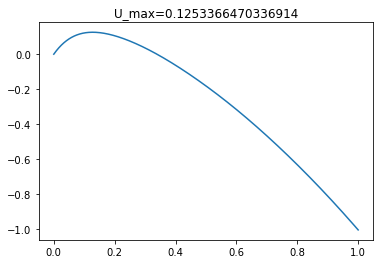

<AxesSubplot:xlabel='$n_{epoch}$', ylabel='$\\phi^{n_{epoch}}$'>

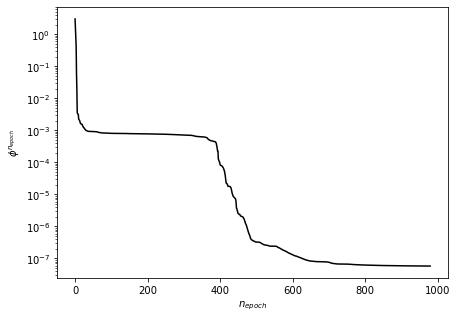

In [28]:
solver.plot_solution()
solver.plot_loss_history()


In [47]:
## Save Model:

import os

model.summary()
checkpoint_path = "success/TryNBC_ub_weight_1_5_5_10-{epoch}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
model.save_weights(checkpoint_path.format(epoch=800))


Model: "pinn__neural_net_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_10 (Lambda)          multiple                  0         
                                                                 
 dense_90 (Dense)            multiple                  60        
                                                                 
 dense_91 (Dense)            multiple                  420       
                                                                 
 dense_92 (Dense)            multiple                  420       
                                                                 
 dense_93 (Dense)            multiple                  420       
                                                                 
 dense_94 (Dense)            multiple                  420       
                                                                 
 dense_95 (Dense)            multiple          

Text(0.5, 1.0, 'U_max=0.0063645243644714355')

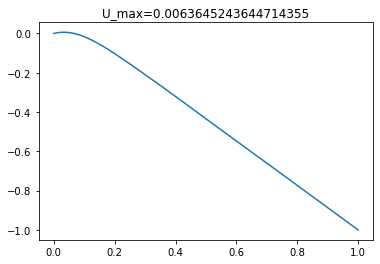

In [96]:
N = 600
tspace = np.linspace(lb[0], ub[0], N + 1)
# T, X = np.meshgrid(tspace)
Xgrid = np.vstack([tspace.flatten(),]).T
# Xgrid.shape
upred = model(tf.cast(Xgrid, DTYPE))
U = upred.numpy().reshape(N+1, 1)
U.shape
# fig = plt.figure(figsize=(9, 6))
# ax = fig.plot()
plt.plot(Xgrid[:,0], U[:,0])
# # ax.view_init(35, 35)
# ax.set_xlabel('$a$')
# ax.set_ylabel('$z$')
# ax.set_zlabel('$v(a,z)$')
plt.title('U_max={}'.format(U.max()))


# # # Surface plot of solution u(t,x)
# fig = plt.figure(figsize=(9, 6))
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(T, X, v_aplot, cmap='viridis')
# ax.view_init(35, 35)
# ax.set_xlabel('$a$')
# ax.set_ylabel('$z$')
# ax.set_zlabel('$\partial v \partial a (a,z)$')
# ax.set_title('Deep Learning Solution')

# fig = plt.figure(figsize=(9, 6))
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(T, X, v_aaplot, cmap='viridis')
# ax.view_init(35, 35)
# ax.set_xlabel('$t$')
# ax.set_ylabel('$x$')
# ax.set_zlabel('$v(a,z)$')
# ax.set_title('Deep Learning Solution')


In [67]:
v_aaplot.min(), v_aaplot.max(), v_aplot.min(), v_aplot.max()


(-0.55985254, -0.013229236, 0.75317144, 1.0986345)

In [94]:
import scipy.io


Vdata = scipy.io.loadmat("Vdata")
V_mat = Vdata['V']
aa_mat = Vdata['aa']
zz_mat = Vdata['zz']

Vadata = scipy.io.loadmat("Vadata")
Va_mat = Vadata['Va_Upwind']
aa_mat = Vadata['aa']
zz_mat = Vadata['zz']


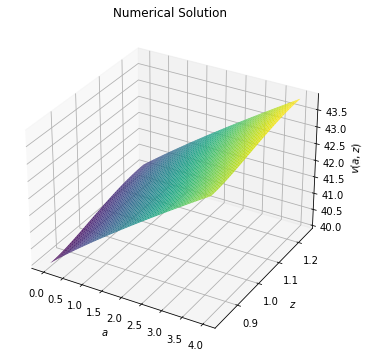

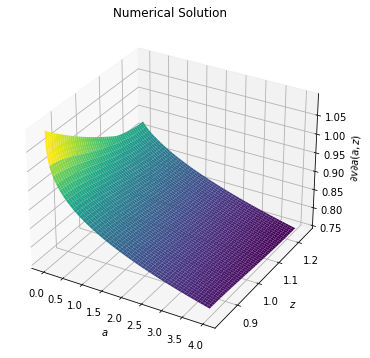

In [95]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(aa_mat, zz_mat, V_mat, cmap='viridis')
# ax.view_init(35, 35)
ax.set_xlabel('$a$')
ax.set_ylabel('$z$')
ax.set_zlabel('$v (a,z)$')
ax.set_title('Numerical Solution')
plt.savefig('HJB_V_mat.pdf', bbox_inches='tight', dpi=300)

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(aa_mat, zz_mat, Va_mat, cmap='viridis')
# ax.view_init(35, 35)
ax.set_xlabel('$a$')
ax.set_ylabel('$z$')
ax.set_zlabel('$\partial v \partial a (a,z)$')
ax.set_title('Numerical Solution')
plt.savefig('HJB_Va_mat.pdf', bbox_inches='tight', dpi=300)

